In [179]:
import pandas as pd
import numpy as np
import seaborn as sns

import yfinance as yf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [180]:
ticker_symbol = 'AAPL'
data = yf.Ticker(ticker_symbol)

In [181]:
prices = data.history(start='2021-01-01', end='2021-04-10').Close

Text(0, 0.5, 'Share Price')

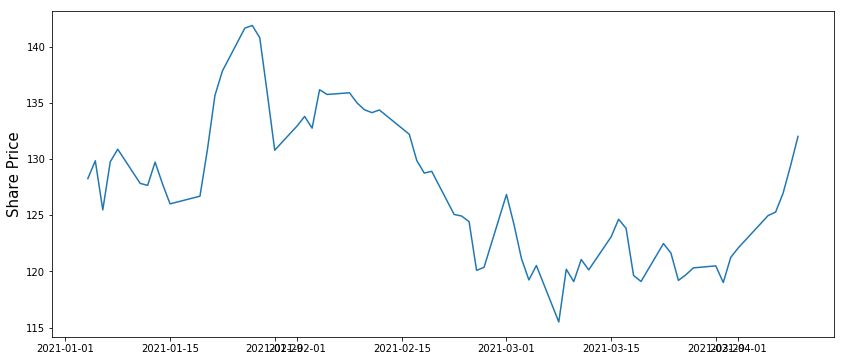

In [182]:
plt.figure(figsize=(14,6))
plt.plot(prices)
plt.ylabel('Share Price', fontsize=15)

## Clearly Prices are not stationary, cannnot fit time series model directly to price data

Text(0, 0.5, 'Daily Return on Apple Share')

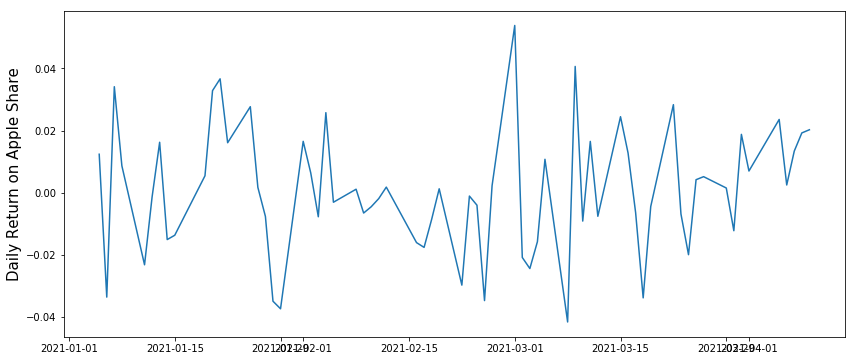

In [183]:
returns = prices.pct_change().dropna()
plt.figure(figsize=(14, 6))
plt.plot(returns)
plt.ylabel("Daily Return on Apple Share", fontsize=15)

### Looks like Stationary, 3 type of Stationary:- 

     1. Trend Stationary
     2. Seasonal Stationary
     3. Strictly Stationary : Joint Distribution of observations

### Augmented Dickey-fuller test (Unit root test)

### Null: Time series data is not stationary
### Alternate: it is stationary

In [184]:
# testing for stationary conditions

from statsmodels.tsa.stattools import adfuller
values = returns.values

res = adfuller(values)

if res[1] > 0.05:
    print("Apple returns are not stationary")
else:
    print("Reject the Null, apple returns are stationary")

Reject the Null, apple returns are stationary


## Fitting the ARMA model in the return series that is already Stationary

### ACF plot will give us number of lags that are to be included as a MA part while PACF plot will give us number of lags that are to be included as a AR part 

In [185]:
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

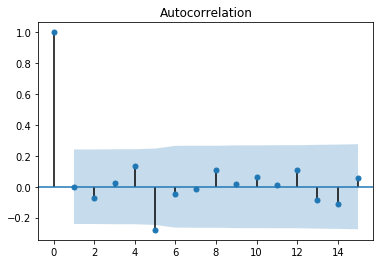

In [186]:
plot_acf(returns, lags=15)
plt.show()

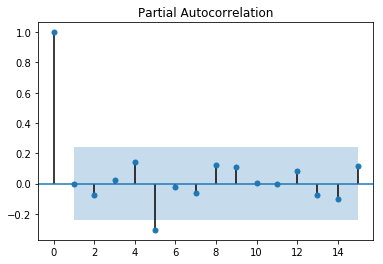

In [187]:
plot_pacf(returns, lags=15)
plt.show()

### Only lag = 5 show a little bit of statistical significance. 

### For the purpose of learning, we will choose lag = 5 for both AR and MA part of fitting ARMA model

## Now we will work on defining a method which will choose to buy or not on any particular day and sell it next day and then try to find whether we can create a strategy around this to generate returns

In [188]:
# for progress bar
from tqdm import tqdm

In [255]:
# plotting the curve where we have bought and sell next day to look whether we have made profit or loss

def plotting_strategy(prices, events_list, final_amt, init_amt):
    plt.figure(figsize=(18,6))
    plt.plot(prices)
    
    y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
    shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)
    
    for idx, event in enumerate(events_list):
        plt.axvline(event[1], color='k', linestyle='--', alpha=0.5)
#         if event[0] == 's':
#             color = 'green' if event[2] > 0 else 'red'
#             plt.fill_between(range(*shaded_y_lims), event[1], events_list[idx-1][1], color=color, alpha=0.1)
    
    tot_return = round(100*(final_amt/init_amt -1 ), 2)
    tot_return = str(tot_return) + '%'

    return

In [258]:
def run_simulation(prices, returns, amt_invested, order_of_arima, threshold, type_of_strategy):
    
    if type_of_strategy == 'random':
        threshold = None
        
    curr_holding = False
    events_list = []
    init_amt = amt_invested
    buy_price = prices.loc[returns.index[0]]
    
    for date, r in tqdm(returns.iloc[:].items(), total=len(returns.iloc[:])):
        # get data till this data as only this info is available to make decision
        curr_data = returns[:date]
        
        # if i have bought last day, then i need to sell it today
        if curr_holding:
            sell_price = prices.loc[date]
#             print(f"Sell Price is {sell_price}" )
            curr_holding = False
            ret = (sell_price - buy_price) / buy_price
            amt_invested *= (1 + ret)
            events_list.append(('s', date, ret))
            
        if type_of_strategy == 'arima':
            try:
                model = ARIMA(curr_data, order=order_of_arima).fit(maxiter=200)
                pred = model.forecast()[0][0] # next day of forecast
            except:
                pred = threshold - 1
        
        # if you pred high positive return and not holding stock, then buy it
        condition_for_random_or_arima = ( (type_of_strategy == 'random' and np.random.random() < order_of_arima) or (type_of_strategy == 'arima' and pred > threshold))
        if (not curr_holding) and condition_for_random_or_arima:
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
#             print(f"Buy Price is {buy_price}" )
            
    print(f"Total amount of {init_amt} end up as {amt_invested}")
    
    plotting_strategy(prices, events_list, amt_invested, init_amt)
    
    return amt_invested, events_list

100%|██████████| 66/66 [00:00<00:00, 2152.78it/s]


Total amount of 100 end up as 108.51592460358397


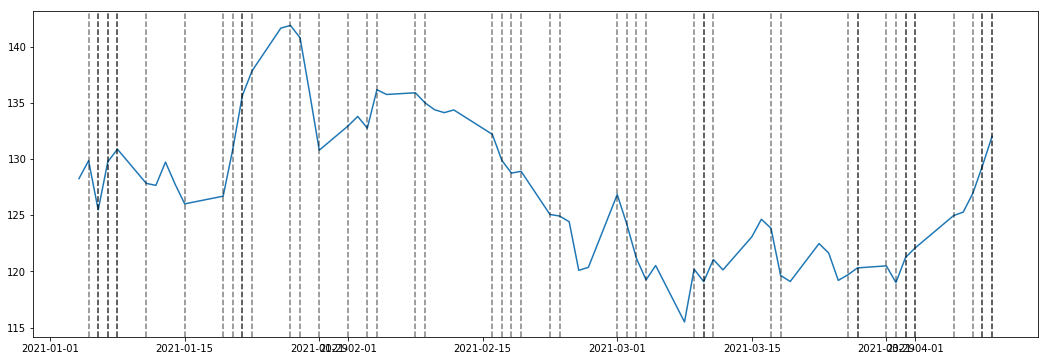

In [259]:
amt_final, event = run_simulation(prices, returns, 100, 0.5, 0.001, 'random')

In [260]:
event

[('b', Timestamp('2021-01-05 00:00:00')),
 ('s', Timestamp('2021-01-06 00:00:00'), -0.03366171537755122),
 ('b', Timestamp('2021-01-06 00:00:00')),
 ('s', Timestamp('2021-01-07 00:00:00'), 0.03412316027573352),
 ('b', Timestamp('2021-01-07 00:00:00')),
 ('s', Timestamp('2021-01-08 00:00:00'), 0.008631409690692336),
 ('b', Timestamp('2021-01-08 00:00:00')),
 ('s', Timestamp('2021-01-11 00:00:00'), -0.023248784983991178),
 ('b', Timestamp('2021-01-15 00:00:00')),
 ('s', Timestamp('2021-01-19 00:00:00'), 0.005427120235233332),
 ('b', Timestamp('2021-01-20 00:00:00')),
 ('s', Timestamp('2021-01-21 00:00:00'), 0.03665836458275032),
 ('b', Timestamp('2021-01-21 00:00:00')),
 ('s', Timestamp('2021-01-22 00:00:00'), 0.01607358736491834),
 ('b', Timestamp('2021-01-26 00:00:00')),
 ('s', Timestamp('2021-01-27 00:00:00'), -0.0076838437005128015),
 ('b', Timestamp('2021-01-29 00:00:00')),
 ('s', Timestamp('2021-02-01 00:00:00'), 0.016520113136245552),
 ('b', Timestamp('2021-02-03 00:00:00')),
 ('s

In [254]:
prices.index = pd.to_datetime(prices.index)